# Insight Data Challenge 1: Breast Cancer Cell Prediction Model

### Callie Bradley | February 2017

Data description: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)

Data: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

In [304]:
import pandas as pd
import numpy as np
import urllib

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

# Model building
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from patsy import dmatrices

# Validation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

## Load the data
Included Attributes:
* Clump Thickness (1-10)
* Uniformity of Cell Size (1-10)
* Uniformity of Cell Shape (1-10)
* Marginal Adhesion (1-10)
* Single Epithelial Cell Size (1-10)
* Bare Nuclei (1-10)
* Bland Chromatin (1-10)
* Normal Nucleoli (1-10)
* Mitoses (1-10)
* Class (2 = benign, 4 = malignant)

In [340]:
link = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
f = urllib.urlopen(link)
df = pd.read_csv(f, header=None)
df.columns = ['id', 'thickness', 'uniformsize', 'uniformshape', 'adhesion','size','barenuclei','chromatin',\
              'normnuclei','mitoses','Class']
df.replace('?', np.NaN, inplace = True)
df.head()

,id,thickness,uniformsize,uniformshape,adhesion,size,barenuclei,chromatin,normnuclei,mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Investigate and Clean the Data

In [341]:
# Investigate nature of data
print "=== Number of null values: ==="
print df.isnull().sum()
print "=============================="
print "Number of entries: ",len(df)
print "Number of begign (2) and malignant (4) tumors: "
print df.Class.value_counts()

=== Number of null values: ===
id               0
thickness        0
uniformsize      0
uniformshape     0
adhesion         0
size             0
barenuclei      16
chromatin        0
normnuclei       0
mitoses          0
Class            0
dtype: int64
Number of entries:  699
Number of begign (2) and malignant (4) tumors: 
2    458
4    241
Name: Class, dtype: int64


In [342]:
# The null values are in the barenuclei category. Find the overall, benign, and malignant means for that category
mean_barenuc = df.barenuclei.astype(float).mean()
mean_barenuc_benign = df.loc[df['Class']==2].barenuclei.astype(float).mean()
mean_barenuc_malig = df.loc[df['Class']==4].barenuclei.astype(float).mean()
print "Bare nuclei mean (Overall): ",mean_barenuc
print "Bare nuclei mean (Benign): ",mean_barenuc_benign
print "Bare nuclei mean (Malignant): ",mean_barenuc_malig

Bare nuclei mean (Overall):  3.54465592972
Bare nuclei mean (Benign):  1.34684684685
Bare nuclei mean (Malignant):  7.62761506276


In [277]:
# Replace null values with the mean corresponding to the class, since nontrivial difference!
df['barenuclei'] = df.barenuclei.astype(float)
df.loc[df['Class']==2].barenuclei.fillna(mean_barenuc_benign, inplace = True)
df.loc[df['Class']==4].barenuclei.fillna(mean_barenuc_malig, inplace = True)

df.Class.replace(2, 0, inplace = True)
df.Class.replace(4, 1, inplace = True)

#df.fillna(mean_barenuc, inplace=True)
df

,id,thickness,uniformsize,uniformshape,adhesion,size,barenuclei,chromatin,normnuclei,mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
5,1017122,8,10,10,8,7,10.0,9,7,1,1
6,1018099,1,1,1,1,2,10.0,3,1,1,0
7,1018561,2,1,2,1,2,1.0,3,1,1,0
8,1033078,2,1,1,1,2,1.0,1,1,5,0
9,1033078,4,2,1,1,2,1.0,2,1,1,0


## Understand the Data

In [264]:
# Look at the data a little more
df.describe() 

,id,thickness,uniformsize,uniformshape,adhesion,size,barenuclei,chromatin,normnuclei,mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.532189,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.602774,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


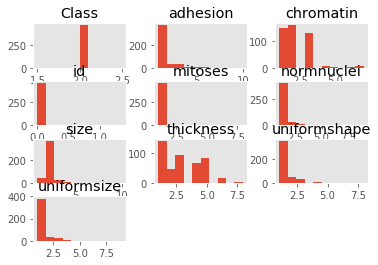

In [177]:
df[df['Class']==2].hist(grid=False);

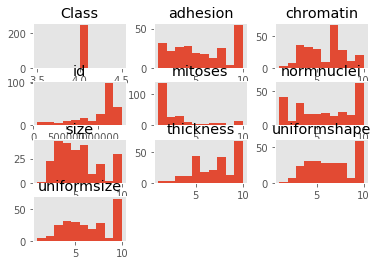

In [178]:
df[df['Class']==4].hist(grid=False);

=== Benign Subset ===
thickness       2.956332
uniformsize     1.325328
uniformshape    1.443231
adhesion        1.364629
size            2.120087
barenuclei      1.397380
chromatin       2.100437
normnuclei      1.290393
mitoses         1.063319
dtype: float64


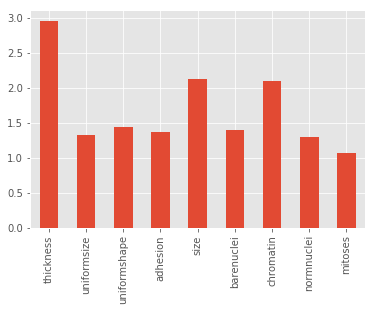

In [339]:
# Could be meaningful to compare the mean of values with benign vs malignant outcomes
df_benign = df.loc[df['Class']==0][['thickness','uniformsize','uniformshape', 'adhesion','size','barenuclei','chromatin',\
              'normnuclei','mitoses']]
means_benign = df_benign.mean()

df_malign = df.loc[df['Class']==1][['thickness','uniformsize','uniformshape', 'adhesion','size','barenuclei','chromatin',\
              'normnuclei','mitoses']]
means_malign = df_malign.mean()

print "=== Benign Subset ==="
print means_benign
means_benign.plot.bar();


=== Malign Subset ===
thickness       7.195021
uniformsize     6.572614
uniformshape    6.560166
adhesion        5.547718
size            5.298755
barenuclei      7.589212
chromatin       5.979253
normnuclei      5.863071
mitoses         2.589212
dtype: float64


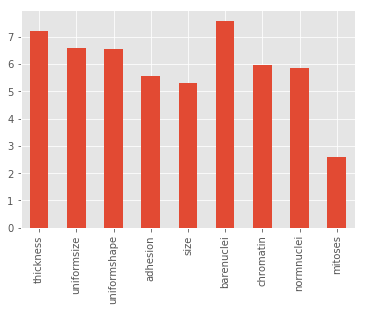

In [333]:
print "=== Malign Subset ==="
print means_malign
means_malign.plot.bar();

In [265]:
# Test amount of correlation to understand how related the parameters are
df.corr()

,id,thickness,uniformsize,uniformshape,adhesion,size,barenuclei,chromatin,normnuclei,mitoses,Class
id,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.097440,-0.060051,-0.052072,-0.034901,-0.080226
thickness,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.588433,0.558428,0.535835,0.350034,0.716001
uniformsize,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.687417,0.755721,0.722865,0.458693,0.817904
uniformshape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.709812,0.735948,0.719446,0.438911,0.818934
adhesion,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666086,0.666715,0.603352,0.417633,0.696800
size,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.582331,0.616102,0.628881,0.479101,0.682785
barenuclei,-0.097440,0.588433,0.687417,0.709812,0.666086,0.582331,1.000000,0.676167,0.577347,0.339844,0.817442
chromatin,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,0.676167,1.000000,0.665878,0.344169,0.756616
normnuclei,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.577347,0.665878,1.000000,0.428336,0.712244
mitoses,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.339844,0.344169,0.428336,1.000000,0.423170


## Build a Model: Random Forest

In [278]:
# We chose to split the data into train and test sets using train_test_split
# We define that Class is a function of the other variables
y, X = dmatrices('Class ~ thickness + uniformsize + uniformshape + adhesion + size + barenuclei + chromatin \
              + normnuclei + mitoses', df, return_type = 'dataframe')
y = np.ravel(y)

# Split data into train and test sets, 80% in train
# random_state is my seed, enabling reproducable results
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 2, stratify = y)
x_dev, x_val, y_dev, y_val = train_test_split(x_train, y_train, train_size = 0.66, random_state = 3, stratify = y_train)

df['barenuclei'] = df.barenuclei.astype(float)
df['barenuclei']

x_dev.head()

,Intercept,thickness,uniformsize,uniformshape,adhesion,size,barenuclei,chromatin,normnuclei,mitoses
7,1.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0
568,1.0,8.0,4.0,4.0,1.0,6.0,10.0,2.0,5.0,2.0
119,1.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
234,1.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,6.0,1.0
653,1.0,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0


In [297]:
# First just try a simple random forest
# Balance the benign vs malignant classes since we have more benign
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 0)

# Train
rf.fit(x_dev,y_dev)

# Validate
print round(rf.score(x_val,y_val)*100,2),"%"

96.86 %


In [268]:
# ... Looking good, but let's look closer: at the ROC curve info, confusion matrix, f1 score

0.976


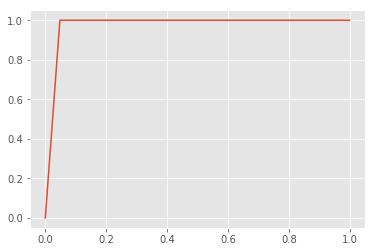

In [298]:
# ROC curve
y_pred = rf.predict(x_val)
roc = roc_auc_score(y_val, y_pred)
fpr, tpr, thresholds = roc_curve(y_val,y_pred)
print auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr)
plt.show()

In [299]:
# Confusion Matrix of the form (L to R, top to bottom: TP, FN, FP, TN)
print "Confusion Matrix: "
print confusion_matrix(y_val, y_pred)
print "F1 Score (optimal value is 1.0): ",sklearn.metrics.f1_score(y_val, y_pred)

Confusion Matrix: 
[[119   6]
 [  0  66]]
F1 Score (optimal value is 1.0):  0.95652173913


Feature ranking:
1. feature 5 (0.263415)
2. feature 6 (0.207083)
3. feature 2 (0.167483)
4. feature 3 (0.116713)
5. feature 8 (0.098648)
6. feature 7 (0.092767)
7. feature 1 (0.030030)
8. feature 4 (0.021062)
9. feature 9 (0.002800)
10. feature 0 (0.000000)


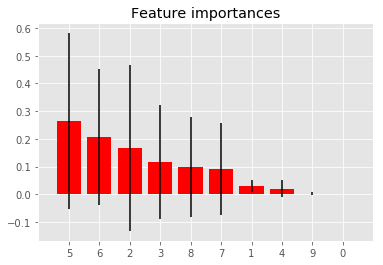

In [301]:
# Let's try looking at what features were most influential in the prediction.
# If the data set was much bigger, we might need to limit the features used in the random forest.
rf.fit(x_dev,y_dev)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_dev.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_dev.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_dev.shape[1]), indices)
plt.xlim([-1, x_dev.shape[1]])
plt.show()

In [302]:
# Looks like we cannot determine which feature(s) are more important

96.34 %
0.972


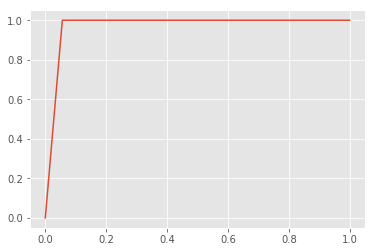

Confusion Matrix: 
[[119   6]
 [  0  66]]
F1 Score (optimal value is 1.0):  0.95652173913


In [308]:
# We still have time, let's try another model variation!
rf2 = ExtraTreesClassifier(n_estimators=250, class_weight = "balanced", random_state=0)

# Train
rf2.fit(x_dev,y_dev)

# Validate
print round(rf2.score(x_val,y_val)*100,2),"%"

y_pred2 = rf2.predict(x_val)
roc2 = roc_auc_score(y_val, y_pred2)
fpr2, tpr2, thresholds2 = roc_curve(y_val,y_pred2)
print auc(fpr2,tpr2)
plt.figure()
plt.plot(fpr2,tpr2)
plt.show()

print "Confusion Matrix: "
print confusion_matrix(y_val, y_pred)
print "F1 Score (optimal value is 1.0): ",sklearn.metrics.f1_score(y_val, y_pred)

In [343]:
# Really similar good output as the first RandomForestClassifier. Interesting that inaccuracies were all false negatives.

### Finally compare to test data

0.963315217391


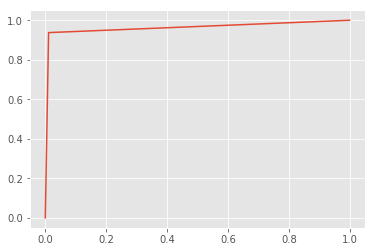

In [345]:
y_predtest = rf.predict(x_test)
roc = roc_auc_score(y_test, y_predtest)
fprtest, tprtest, thresholdstest = roc_curve(y_test,y_predtest)
print auc(fprtest,tprtest)
plt.figure()
plt.plot(fprtest,tprtest)
plt.show()

## Interpret the Results

We were able to make a reasonably accurate prediction using a random forest classifier, to predict whether the tumors would be benign or malignant. The different features seemed about equally important - we did not have enough data to discriminate which features were of more importance using this model. 

Treating NaN values with mean of all values in the column or mean of the benign/malignant status did not make a significant difference.

Our RandomForestClassifier was more accurate than the ExtraTreesClassifier.